!pip install pyarrow

In [1]:
import pandas as pd

In [2]:
pd.__version__


'1.4.2'

In [3]:
df_01 = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')
df_02 = pd.read_parquet('./data/yellow_tripdata_2023-02.parquet')

In [4]:
frames = [df_01, df_02]

result = pd.concat(frames)

In [ ]:
result.tail()

## Q1. Downloading the data

1. Read the data for January. How many columns are there?

In [5]:
# Getting the list of columns 
col = df_01.columns 

# Printing Number of columns 
print('Number of columns of dataframe from January:', len(col)) 


Number of columns of dataframe from January: 19


## Q2. Computing duration

2. Now let's compute the duration variable. It should contain the duration of a ride in minutes. What's the standard deviation of the trips duration in January?

In [7]:
df_01.std()

/tmp/ipykernel_43365/726372631.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_01.std()


VendorID                                  0.443848
tpep_pickup_datetime     9 days 15:29:51.002042903
tpep_dropoff_datetime    9 days 15:29:27.269195801
passenger_count                            0.89612
trip_distance                           249.583756
RatecodeID                                6.474767
PULocationID                             64.244131
DOLocationID                             69.943682
payment_type                              0.529476
fare_amount                              17.807822
extra                                     1.789592
mta_tax                                   0.103464
tip_amount                                3.826759
tolls_amount                              2.017579
improvement_surcharge                     0.183353
total_amount                             22.163589
congestion_surcharge                      0.771845
airport_fee                               0.355651
dtype: object

In [6]:
df_01['min_diff'] = (df_01.tpep_dropoff_datetime - df_01.tpep_pickup_datetime) / pd.Timedelta(minutes=1)

In [7]:
df_01['min_diff'].std()

42.594351241920904

## Q3. Dropping outliers


3. Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive). What fraction of the records left after you dropped the outliers?

In [8]:
duration = df_01.copy()
duration['duration'] = duration['min_diff']

In [9]:
duration_f = duration[(duration['duration'] >= 1) & (duration['duration'] <= 60)]

duration_f.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,min_diff,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,...,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,...,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333,10.833333


In [10]:
fraction_remaining = len(duration_f['duration']) / len(duration['duration'])
print('fraction of the records' , fraction_remaining*100)

fraction of the records 98.1220282212598


## Q4. One-hot encoding

In [35]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [12]:
dur_q4 = duration_f.copy()
dur_q4['VendorID'] = dur_q4['VendorID'].astype(str)
#dur_q4 = dur_q4[['VendorID','PULocationID','DOLocationID']]
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

In [13]:
dur_q4[categorical]=dur_q4[categorical].astype(str)

In [14]:
dur_q4.dtype

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [15]:
#dur_q4[categorical + numerical].iloc[0:3009173].to_dict(orient='records')
train_dicts = dur_q4[categorical + numerical].to_dict(orient='records')

In [16]:
#records = dur_q4.to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [17]:
X_train

<3009173x516 sparse matrix of type '<class 'numpy.float64'>'
	with 9027519 stored elements in Compressed Sparse Row format>

## Q5. Training a model

5. Now let's use the feature matrix from the previous step to train a model. Train a plain linear regression model with default parameters, where duration is the response variable Calculate the RMSE of the model on the training data What's the RMSE on train?

In [19]:
#dv.feature_names_

In [21]:
target = 'duration'
y_train = dur_q4[target].values

In [22]:
y_train

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

In [25]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [26]:
y_pred = lr.predict(X_train)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


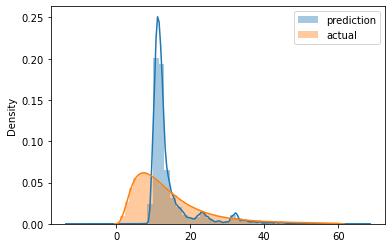

In [29]:
sns.distplot(y_pred, label = 'prediction')
sns.distplot(y_train, label = 'actual')

plt.legend()

In [36]:
mean_squared_error(y_train, y_pred, squared=False)

7.649143388169879

## Q6. Evaluating the model


6. Now let's apply this model to the validation dataset (February 2023). What's the RMSE on validation